## Importing Packages

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import json
from utils.random import random_lba_2A
from utils.utils import get_dfs, calculate_waic, bci, plot_mean_posterior
import ipywidgets as widgets

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Choose Model

#### roots

In [3]:
root = "../"
plots_root = "Results/hierarchical/Plots/"
datasets_root = root + "Datasets/"
behavioural_data_root = datasets_root +  "behavioral_data/selected_data/" 
stan_files_root = root +  "models/stan/" 
saved_models_root = "Results/hierarchical/stan_results/"

model_config = {}
plots_path = ""
dataset_path = ""
stan_file_path = ""
stan_output_dir = ""

#### read models configuration json file

In [4]:
with open("../models/lba_based_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())

#### Choose and set model configuration

In [5]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config["plots_folder_name"] + "/"
    dataset_path = datasets_root + "AI Models Results/" + model_config["dataset_name"]
    stan_file_path = stan_files_root + model_config["stan_file"]
    stan_output_dir = saved_models_root + model_config["model_name"] + "/"
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('LBA_cd', 'LBA_ndm', 'ANN-LBA_l_FT', 'ANN-LB…

In [6]:
model_config

{'model_name': 'ANN-LBA_s_am_FT',
 'stan_file': 'ANN-LBA/sigmoid_am.stan',
 'dataset_name': 'fastText_FC.csv',
 'plots_folder_name': 'ANN-LBA_s_am_FT',
 'transf_params': ['transf_mu_k_word',
  'transf_mu_k_nonword',
  'transf_mu_sp_trial_var_word',
  'transf_mu_sp_trial_var_nonword',
  'transf_mu_ndt',
  'transf_mu_alpha',
  'transf_mu_b',
  'transf_mu_theta_1',
  'transf_mu_theta_2',
  'transf_mu_drift_variability']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [7]:
word_nword_df = pd.read_csv(dataset_path, header=None,
                            names =["string", "freq",  "label", "zipf",
                                    "category", "word_prob", "non_word_prob"])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,Ipe's,0,0,0.000000,NW,6.484266e-08,9.999998e-01
1,toothcamb,0,0,0.000000,NW,4.641062e-05,9.999536e-01
2,flicks,702,1,2.935287,LF,9.993498e-01,6.502719e-04
3,Samoar,0,0,0.000000,NW,1.966545e-06,9.999980e-01
4,lastened,0,0,0.000000,NW,1.107923e-04,9.998892e-01
...,...,...,...,...,...,...,...
74312,drased,0,0,0.000000,NW,6.662523e-05,9.999334e-01
74313,exorcism,238,1,3.274105,HF,9.999999e-01,7.543648e-08
74314,pobs,0,0,0.000000,NW,1.563252e-07,9.999999e-01
74315,undemonstrative,3,1,1.592864,LF,9.999452e-01,5.486609e-05


In [8]:
# Reading LDT Data
behavioural_df = pd.read_csv(behavioural_data_root + "LDT_data.csv",
                             header=None,
                             names=["accuracy", "rt", "string", "response",
                                    "participant", "minRT", "participant_id"])
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on="string", how="left").dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["freq", "participant"], axis=1)

In [9]:
behavioural_df.head()

,accuracy,rt,string,response,minRT,participant_id,label,zipf,category,word_prob,non_word_prob
0,1,0.422,sand,1,0.422,1,1.0,4.307194,HF,0.999509,0.000491
1,1,0.462,textbook,1,0.422,1,1.0,3.344913,HF,0.999996,0.000003
2,0,0.490,carmed,1,0.422,1,0.0,0.000000,NW,0.000087,0.999913
3,1,0.503,pain,1,0.422,1,1.0,4.990457,HF,0.999988,0.000012
4,1,0.513,technical,1,0.422,1,1.0,3.916116,HF,0.999640,0.000360


In [10]:
# Reducing size of dataframe for testing purposes
behavioural_df = behavioural_df.loc[behavioural_df["participant_id"].isin(np.arange(3))]

Predicted probabilities of words and non-words in different conditions in all trials
across participants

## Stan Model and Estimation

Compiling stan model

In [11]:
lba_model = cmdstanpy.CmdStanModel(model_name=model_config['model_name'],
                                   stan_file=stan_file_path);

21:23:24 - cmdstanpy - INFO - compiling stan file E:\Workspace\Thesis\ANN-EAM\models\stan\ANN-LBA\sigmoid_am.stan to exe file E:\Workspace\Thesis\ANN-EAM\models\stan\ANN-LBA\sigmoid_am.exe
21:24:07 - cmdstanpy - INFO - compiled model executable: E:\Workspace\Thesis\ANN-EAM\models\stan\ANN-LBA\sigmoid_am.exe
21:24:07 - cmdstanpy - WARNING - Stan compiler has produced 32 warnings:
21:24:07 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-LBA/sigmoid_am.hpp E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-LBA/sigmoid_am.stan
Warning in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-LBA/sigmoid_am.stan', line 110, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'E:/Workspace/Thesis/ANN-EAM/models/sta

Preparing model's inputs

note that some inputs of data_dict might not be used depending on which model is used

In [12]:
N = len(behavioural_df)                                                    # For all models
participant = behavioural_df['participant_id'].to_numpy()                     # For all models
p = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df['zipf'].to_numpy().astype(int)                  # zipf values For models with non-decision time or drift modulation
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df['response'].to_numpy().astype(int)               # for all models
rt = behavioural_df['rt'].to_numpy()                                       # for all models
minRT = behavioural_df['minRT'].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models
Number_Of_Participants = len(set(behavioural_df['participant_id']))

k_priors = [0, 1, 1, 1]                  # All models with LBA
A_priors = [1, 2, 1, 1]                  # All models wtih LBA
ndt_priors = [0, 1, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models withoud drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
# There is a k parameter in LBA impelemention so we use theta as k parameter in sigmoid function
theta_priors = [2, 1, 1, 1]              # For models with sigmoid drift mapping functions (ANN-EAM models) (equivalent of k_priors in RDM and ANN-RDM)
sp_trial_var_priors = [1, 1, 0, 1]
drift_variability_priors = [1, 1, 1, 1]

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'frequency': frequency,
             'frequencyCondition': frequencyCondition,
             'k_priors': k_priors,
             'A_priors': A_priors,
             'ndt_priors': ndt_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'drift_priors': drift_priors,
             'p': p,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
             'theta_priors': theta_priors,
             'sp_trial_var_priors': sp_trial_var_priors,
             'drift_variability_priors': drift_variability_priors
             }

# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [13]:
fit = lba_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

21:24:34 - cmdstanpy - INFO - Chain [1] start processing
21:24:34 - cmdstanpy - INFO - Chain [2] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 250
Chain [1] num_warmup = 250
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = C:\Users\Arash\AppData\Local\Temp\tmpmwz_9svu\s3m190ed.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 18200
Chain [1] outp

21:32:03 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 222.313 seconds (Warm-up)
Chain [1] 226.3 seconds (Sampling)
Chain [1] 448.613 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
C

21:32:51 - cmdstanpy - INFO - Chain [2] done processing
21:32:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-LBA/sigmoid_am.stan', line 26, column 8 to column 34) (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-LBA/sigmoid_am.stan', line 84, column 20 to column 88) (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-LBA/sigmoid_am.stan', line 276, column 4 to line 277, column 72)
	Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-LBA/sigmoid_am.stan', line 26, column 8 to column 34) (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-LBA/sigmoid_am.stan', line 84, column 20 to column 88) (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-LBA/sigmoid_am.stan', line 276, column 4 to line 277, column 72)
	Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'E:/Workspace/Thesis/AN

Chain [2] 
Chain [2] Elapsed Time: 249.334 seconds (Warm-up)
Chain [2] 246.894 seconds (Sampling)
Chain [2] 496.228 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 

## Loading Model

(In case model have been fitted before)

In [14]:
# fit = cmdstanpy.from_csv(stan_output_dir)

## Model diagnostics

In [15]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: E:\Workspace\Thesis\ANN-EAM\Estimations\Results\hierarchical\stan_results\ANN-LBA_s_am_FT\ANN-LBA_s_am_FT-20230610212434_1.csv, E:\Workspace\Thesis\ANN-EAM\Estimations\Results\hierarchical\stan_results\ANN-LBA_s_am_FT\ANN-LBA_s_am_FT-20230610212434_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [16]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-129.988000,0.536980,5.989860,-140.693000,-129.473000,-120.90400,124.428,0.262953,1.021430
mu_k_word,0.271723,0.042525,0.581046,-0.736066,0.288844,1.17214,186.692,0.394535,1.003070
mu_k_nonword,0.682986,0.042389,0.625177,-0.507487,0.734732,1.66936,217.521,0.459687,1.000680
mu_sp_trial_var_word,0.163205,0.032175,0.532255,-0.669327,0.151586,1.03428,273.653,0.578310,1.000840
mu_sp_trial_var_nonword,0.762474,0.032909,0.640907,-0.331966,0.753705,1.77987,379.279,0.801530,0.997878
...,...,...,...,...,...,...,...,...,...
log_lik[737],-2.978420,0.010146,0.269354,-3.478160,-2.951840,-2.54807,704.794,1.489440,0.996343
log_lik[738],-2.574010,0.007520,0.182217,-2.870180,-2.564720,-2.28392,587.064,1.240640,0.999984
log_lik[739],-4.387330,0.019069,0.415813,-5.121450,-4.360400,-3.76824,475.478,1.004830,0.999445
log_lik[740],-2.751560,0.008119,0.192827,-3.069560,-2.747140,-2.44467,564.064,1.192040,1.000000


In [17]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
761


In [18]:
df.loc[df["R_hat"]>1.01].to_csv("Results/hierarchical/logs/" + model_config["model_name"] + "_rhat_log.csv")

In [19]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-129.988000,0.536980,5.989860,-140.693000,-129.473000,-120.904000,124.428,0.262953,1.02143
z_k_word[1],-0.091296,0.063905,0.790880,-1.544260,-0.052777,1.102810,153.162,0.323677,1.01258
ndt_t[1],0.195935,0.003016,0.051718,0.110692,0.197579,0.282195,294.018,0.621348,1.01818
ndt_t[2],0.195935,0.003016,0.051718,0.110692,0.197579,0.282195,294.018,0.621348,1.01818
ndt_t[3],0.195935,0.003016,0.051718,0.110692,0.197579,0.282195,294.018,0.621348,1.01818
...,...,...,...,...,...,...,...,...,...
log_lik[263],-0.778282,0.006400,0.134238,-1.025830,-0.774991,-0.567048,439.904,0.929649,1.01127
log_lik[645],-1.041680,0.010441,0.152486,-1.308410,-1.037800,-0.797937,213.290,0.450745,1.01059
log_lik[646],-1.045070,0.010452,0.152547,-1.311450,-1.041350,-0.801905,213.022,0.450178,1.01061
log_lik[662],-1.212800,0.010833,0.156524,-1.488830,-1.202270,-0.962249,208.764,0.441180,1.01083


In [20]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000
mean,-0.027549,0.004419,0.057448,-0.107808,-0.031152,0.080671,199.473419,0.421547,1.021410
std,4.719999,0.019536,0.219951,5.107753,4.701119,4.393462,101.315628,0.214110,0.003761
min,-129.988000,0.003016,0.038792,-140.693000,-129.473000,-120.904000,97.367200,0.205766,1.010070
25%,0.132404,0.003016,0.038792,0.101627,0.121495,0.226175,97.367200,0.205766,1.018180
50%,0.132404,0.003931,0.051718,0.101627,0.121495,0.226175,294.018000,0.621348,1.018180
75%,0.195935,0.003931,0.051718,0.110692,0.197579,0.282195,294.018000,0.621348,1.025130
max,0.500013,0.536980,5.989860,0.284629,0.477667,1.102810,439.904000,0.929649,1.025130


## Check parameters

Parameters posterior plots

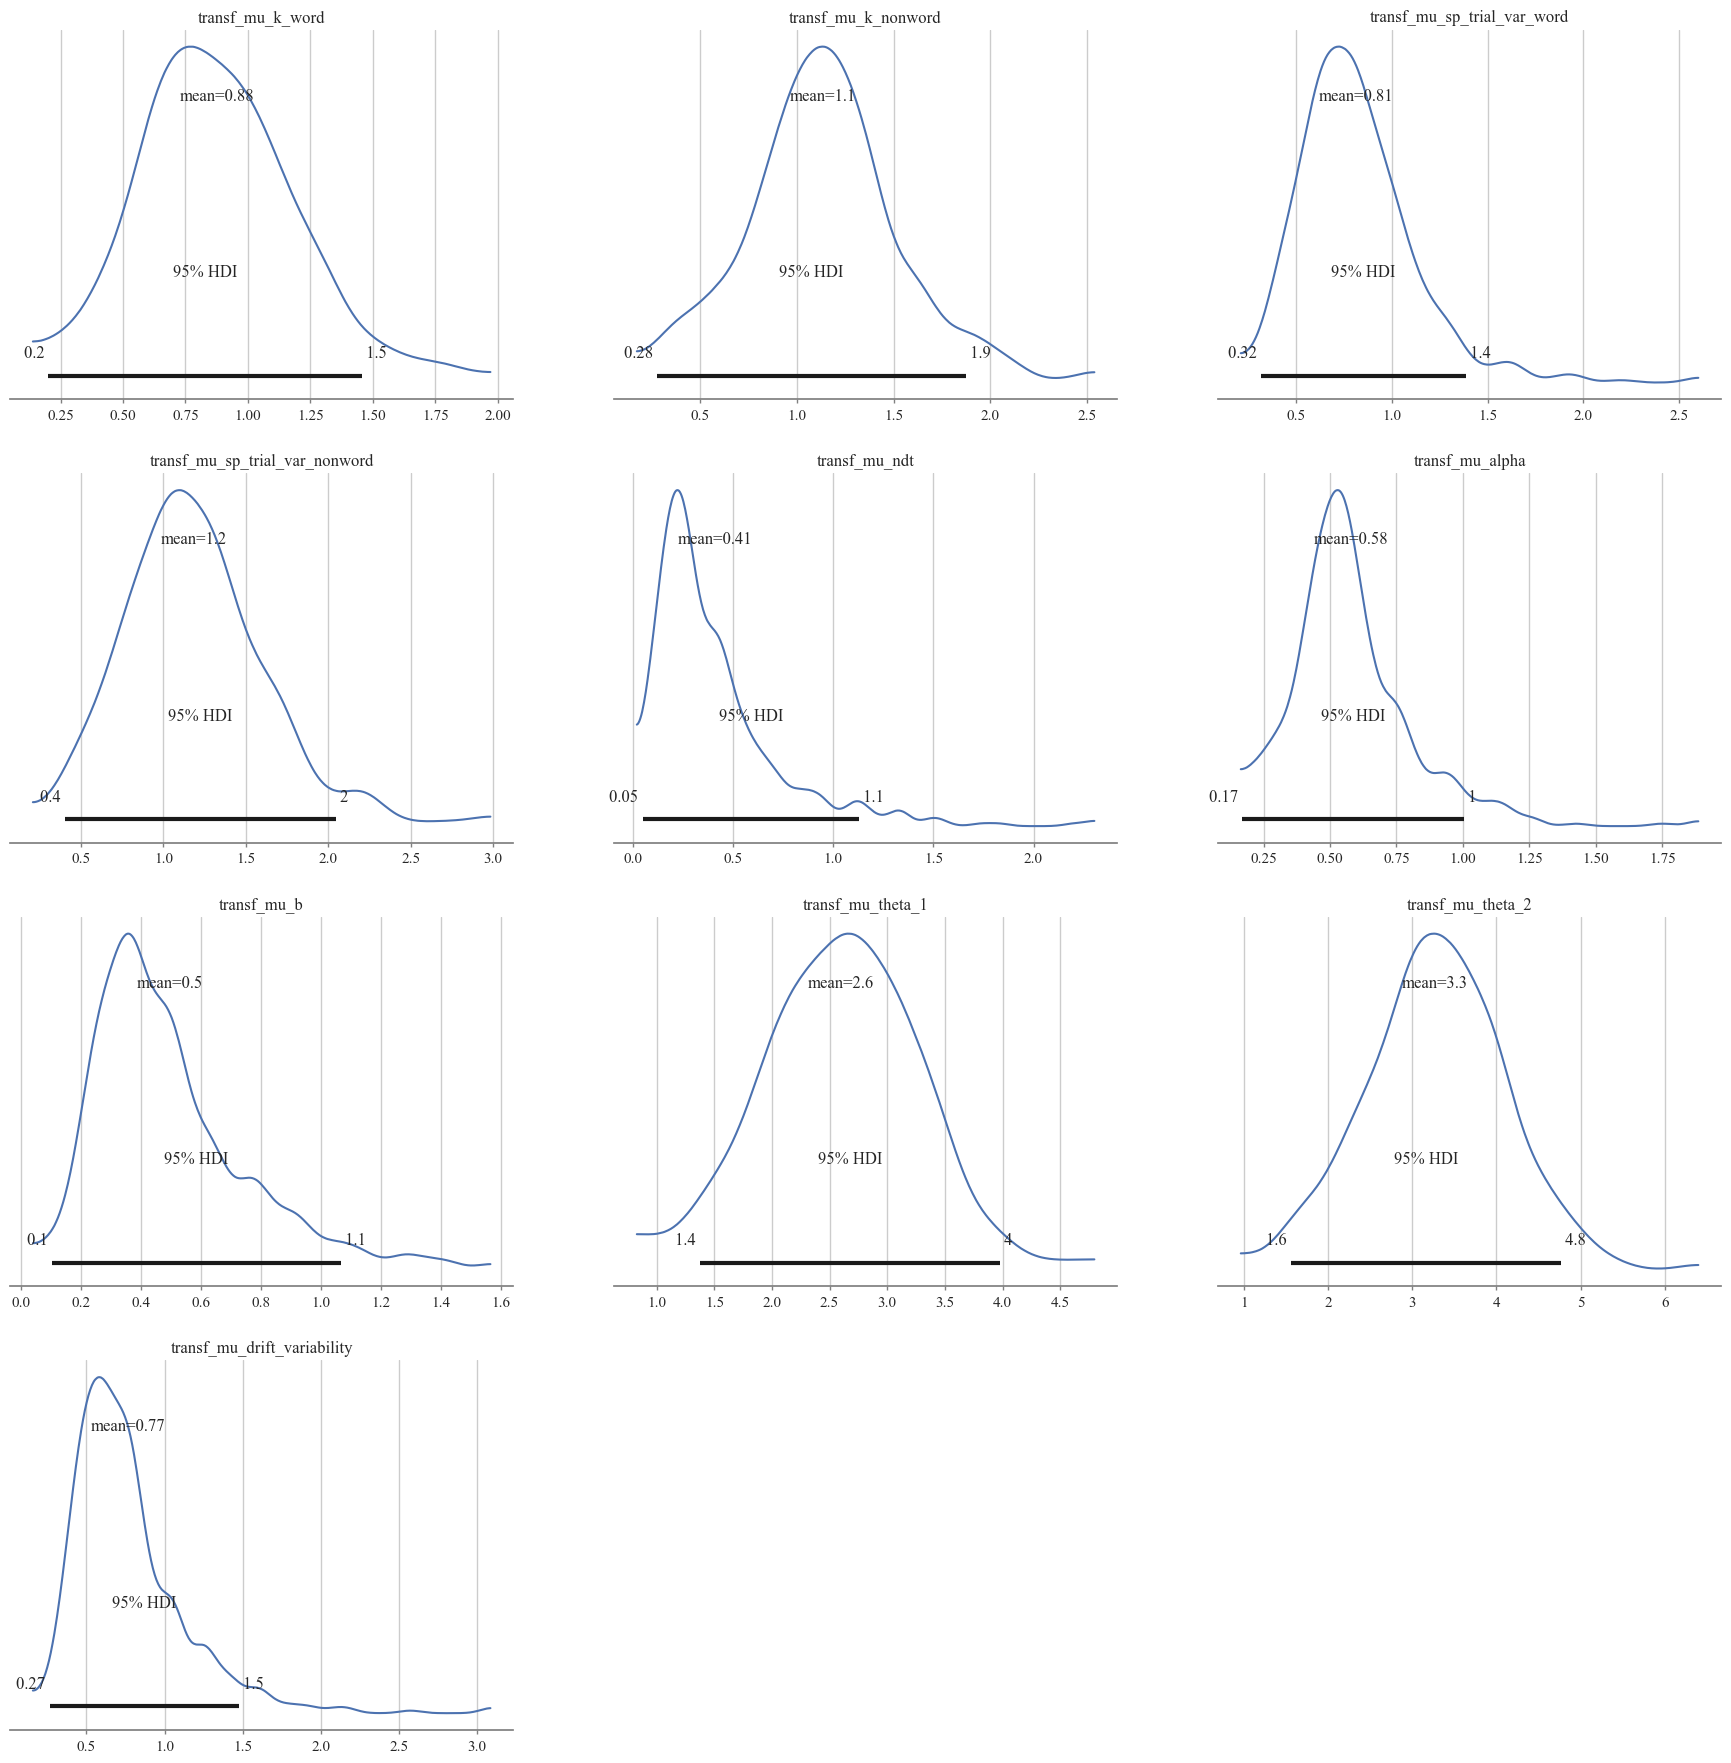

In [21]:
az.plot_posterior(fit, var_names=model_config['transf_params'],
                  hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

Loading model parameters for each trial

In [22]:
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
ndt_t = fit.stan_variables()['ndt_t']
drift_variability_t = fit.stan_variables()['drift_variability_t']
if model_config['model_name'] != "LBA":
    k_t_word = fit.stan_variables()['k_t_word']
    k_t_nonword = fit.stan_variables()['k_t_nonword']
    sp_t_word = fit.stan_variables()['sp_trial_var_t_word']
    sp_t_nonword = fit.stan_variables()['sp_trial_var_t_nonword']

else:
    k_t = fit.stan_variables()['k_t']
    sp_trial_var_t = fit.stan_variables()['sp_trial_var_t']

#### Models mean parameters in different conditions

In [23]:
v_HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
v_HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
v_LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
v_LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
v_NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
v_NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [24]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(v_HF_condition_w, axis=1)), np.std(np.mean(v_HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(v_HF_condition_nw, axis=1)), np.std(np.mean(v_HF_condition_nw, axis=1)))
print('LF words word drift mean and std:')
print(np.mean(np.mean(v_LF_condition_w, axis=1)), np.std(np.mean(v_LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(v_LF_condition_nw, axis=1)), np.std(np.mean(v_LF_condition_nw, axis=1)))
print('NW words word drift mean and std:')
print(np.mean(np.mean(v_NW_condition_w, axis=1)), np.std(np.mean(v_NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(v_NW_condition_nw, axis=1)), np.std(np.mean(v_NW_condition_nw, axis=1)))

HF words, word drift mean and std:
2.3749332704528308 0.532007727986473
HF words, nonword drift mean and std:
1.9582150705283021 0.4376931596391627
LF words word drift mean and std:
2.0305671569206347 0.45402961538350756
LF words nonword drift mean and std:
1.960825357724868 0.4381473263220461
NW words word drift mean and std:
1.2414269527124684 0.27911300859585636
NW words nonword drift mean and std:
2.5580675408295166 0.5732194387483582


In [25]:
if model_config['model_name'] != "LBA":
    sp_HF_condition_w = sp_t_word[:, behavioural_df['category']=="HF"]
    sp_HF_condition_nw = sp_t_nonword[:, behavioural_df['category']=="HF"]
    sp_LF_condition_w = sp_t_word[:, behavioural_df['category']=="LF"]
    sp_LF_condition_nw = sp_t_nonword[:, behavioural_df['category']=="LF"]
    sp_NW_condition_w = sp_t_word[:, behavioural_df['category']=="NW"]
    sp_NW_condition_nw = sp_t_nonword[:, behavioural_df['category']=="NW"]
else:
    sp_HF_condition = sp_trial_var_t[:, behavioural_df['category']=="HF"]
    sp_LF_condition = sp_trial_var_t[:, behavioural_df['category']=="LF"]
    sp_NW_condition = sp_trial_var_t[:, behavioural_df['category']=="NW"]

In [26]:
if model_config['model_name'] != "LBA":
    print('HF words, word starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition_w, axis=1)), np.std(np.mean(sp_HF_condition_w, axis=1)))
    print('HF words, nonword starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition_nw, axis=1)), np.std(np.mean(sp_HF_condition_nw, axis=1)))
    print('LF words word starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition_w, axis=1)), np.std(np.mean(sp_LF_condition_w, axis=1)))
    print('LF words nonword starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition_nw, axis=1)), np.std(np.mean(sp_LF_condition_nw, axis=1)))
    print('NW words word starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition_w, axis=1)), np.std(np.mean(sp_NW_condition_w, axis=1)))
    print('NW words nonword starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition_nw, axis=1)), np.std(np.mean(sp_NW_condition_nw, axis=1)))
else:
    print('HF words, starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition, axis=1)), np.std(np.mean(sp_HF_condition, axis=1)))
    print('LF words starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition, axis=1)), np.std(np.mean(sp_LF_condition, axis=1)))
    print('NW words starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition, axis=1)), np.std(np.mean(sp_NW_condition, axis=1)))

HF words, word starting point mean and std:
0.709221672354717 0.21167659084636306
HF words, nonword starting point mean and std:
1.1559878703220128 0.34860581344939057
LF words word starting point mean and std:
0.7094824457714287 0.2116064086962707
LF words nonword starting point mean and std:
1.1576423281079364 0.3492047056541183
NW words word starting point mean and std:
0.7085658819541986 0.21187961864830676
NW words nonword starting point mean and std:
1.1518272563002552 0.34716473850691887


In [27]:
if model_config['model_name'] != "LBA":
    k_HF_condition_w = k_t_word[:, behavioural_df['category']=="HF"]
    k_HF_condition_nw = k_t_nonword[:, behavioural_df['category']=="HF"]
    k_LF_condition_w = k_t_word[:, behavioural_df['category']=="LF"]
    k_LF_condition_nw = k_t_nonword[:, behavioural_df['category']=="LF"]
    k_NW_condition_w = k_t_word[:, behavioural_df['category']=="NW"]
    k_NW_condition_nw = k_t_nonword[:, behavioural_df['category']=="NW"]

    t_HF_condition_w = sp_HF_condition_w + sp_HF_condition_w
    t_HF_condition_nw = sp_HF_condition_nw + sp_HF_condition_nw
    t_LF_condition_w = sp_LF_condition_w + sp_LF_condition_w
    t_LF_condition_nw = sp_LF_condition_nw + sp_LF_condition_nw
    t_NW_condition_w = sp_NW_condition_w + sp_NW_condition_w
    t_NW_condition_nw = sp_NW_condition_nw + sp_NW_condition_nw
else:
    k_HF_condition = k_t[:, behavioural_df['category']=="HF"]
    k_LF_condition = k_t[:, behavioural_df['category']=="LF"]
    k_NW_condition = k_t[:, behavioural_df['category']=="NW"]

    t_HF_condition = sp_HF_condition + k_HF_condition
    t_LF_condition = sp_LF_condition + k_LF_condition
    t_NW_condition = sp_NW_condition + k_NW_condition

In [28]:
if model_config['model_name'] != "LBA":
    print('HF words, word threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_w, axis=1)), np.std(np.mean(t_HF_condition_w, axis=1)))
    print('HF words, nonword threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_nw, axis=1)), np.std(np.mean(t_HF_condition_nw, axis=1)))
    print('LF words word threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_w, axis=1)), np.std(np.mean(t_LF_condition_w, axis=1)))
    print('LF words nonword threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_nw, axis=1)), np.std(np.mean(t_LF_condition_nw, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_w, axis=1)), np.std(np.mean(t_NW_condition_w, axis=1)))
    print('NW words nonword threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_nw, axis=1)), np.std(np.mean(t_NW_condition_nw, axis=1)))
else:
    print('HF words,  threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition, axis=1)), np.std(np.mean(t_HF_condition, axis=1)))
    print('LF words threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition, axis=1)), np.std(np.mean(t_LF_condition, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition, axis=1)), np.std(np.mean(t_NW_condition, axis=1)))

HF words, word threshold mean and std:
1.418443344709434 0.4233531816927261
HF words, nonword threshold mean and std:
2.3119757406440256 0.6972116268987811
LF words word threshold mean and std:
1.4189648915428574 0.4232128173925414
LF words nonword threshold mean and std:
2.315284656215873 0.6984094113082366
NW words word threshold mean and std:
1.4171317639083971 0.4237592372966135
NW words nonword threshold mean and std:
2.3036545126005104 0.6943294770138377


In [29]:
if model_config['model_name'] != "LBA":
    bias_HF_condition_w = t_HF_condition_w - sp_HF_condition_w
    bias_HF_condition_nw = t_HF_condition_nw - sp_HF_condition_nw
    bias_LF_condition_w = t_LF_condition_w - sp_LF_condition_w
    bias_LF_condition_nw = t_LF_condition_nw - sp_LF_condition_nw
    bias_NW_condition_w = t_NW_condition_w - sp_NW_condition_w
    bias_NW_condition_nw = t_NW_condition_nw - sp_NW_condition_nw

In [30]:
if model_config['model_name'] != "LBA":
    print('HF words, word bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_w, axis=1)), np.std(np.mean(bias_HF_condition_w, axis=1)))
    print('HF words, nonword bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_nw, axis=1)), np.std(np.mean(bias_HF_condition_nw, axis=1)))
    print('LF words word bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_w, axis=1)), np.std(np.mean(bias_LF_condition_w, axis=1)))
    print('LF words nonword bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_nw, axis=1)), np.std(np.mean(bias_LF_condition_nw, axis=1)))
    print('NW words word bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_w, axis=1)), np.std(np.mean(bias_NW_condition_w, axis=1)))
    print('NW words nonword bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_nw, axis=1)), np.std(np.mean(bias_NW_condition_nw, axis=1)))

HF words, word bias mean and std:
0.709221672354717 0.21167659084636306
HF words, nonword bias mean and std:
1.1559878703220128 0.34860581344939057
LF words word bias mean and std:
0.7094824457714287 0.2116064086962707
LF words nonword bias mean and std:
1.1576423281079364 0.3492047056541183
NW words word bias mean and std:
0.7085658819541986 0.21187961864830676
NW words nonword bias mean and std:
1.1518272563002552 0.34716473850691887


In [31]:
ndt_HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
ndt_LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
ndt_NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [32]:
print('HF words ndt mean and std:')
print(np.mean(np.mean(ndt_HF_condition, axis=1)), np.std(np.mean(ndt_HF_condition, axis=1)))
print('LF words ndt mean and std:')
print(np.mean(np.mean(ndt_LF_condition, axis=1)), np.std(np.mean(ndt_LF_condition, axis=1)))
print('Non Words ndt mean and std:')
print(np.mean(np.mean(ndt_NW_condition, axis=1)), np.std(np.mean(ndt_NW_condition, axis=1)))

HF words ndt mean and std:
0.1639701291320755 0.035667184524652285
LF words ndt mean and std:
0.1636656980952381 0.03559107847398336
Non Words ndt mean and std:
0.16473570928244266 0.0358670275166647


## Calculating metrics

In [33]:
log_likelihood = fit.stan_variables()['log_lik']
print(calculate_waic(log_likelihood))

{'lppd': -100.07763837496692, 'p_waic': 22.33116683166437, 'waic': 244.81761041326257, 'waic_se': 69.05393217885873}


## Simulating LBA with estimated parameters

Simulating LBA with estimated parameters

In [34]:
if model_config["model_name"] != "RDM":
    pp_rt, pp_response = random_lba_2A(drift_word_t, drift_nonword_t, sp_t_word, sp_t_nonword,
                                       ndt_t, k_t_word, k_t_nonword, drift_variability_t)
else:
    pp_rt, pp_response = random_lba_2A(drift_word_t, drift_nonword_t, sp_trial_var_t, sp_trial_var_t,
                                       ndt_t, k_t, k_t, drift_variability_t)

In [35]:
# Predicted Data
tmp1 = pd.DataFrame(pp_rt,
                    index=pd.Index(np.arange(1, len(pp_rt)+1), name="sample"),
                    columns=pd.MultiIndex.from_product((["rt"],
                                                        np.arange(pp_rt.shape[1])),
                                                        names=["variable", "trial"]))
tmp2 = pd.DataFrame(pp_response,
                    index=pd.Index(np.arange(1, len(pp_response)+1), name="sample"),
                    columns=pd.MultiIndex.from_product((["response"],
                                                        np.arange(pp_response.shape[1])),
                                                               names=["variable", "trial"]))
predictedData = pd.concat((tmp1, tmp2), axis=1)

## RT Quantiles Posterior Predictions Checks

In [36]:
quantiles = [.1, .3, .5, .7, .9]

### All Trials

In [37]:
exp_all_trials, pred_all_trials = get_dfs(behavioural_df, predictedData)

In [38]:
all_quantiles_ex = exp_all_trials["rt"].quantile(quantiles)
all_quantiles_pred = pred_all_trials.quantile(quantiles, axis=1).T
all_predicted_bci = np.array([bci(all_quantiles_pred[x]) for x in quantiles])

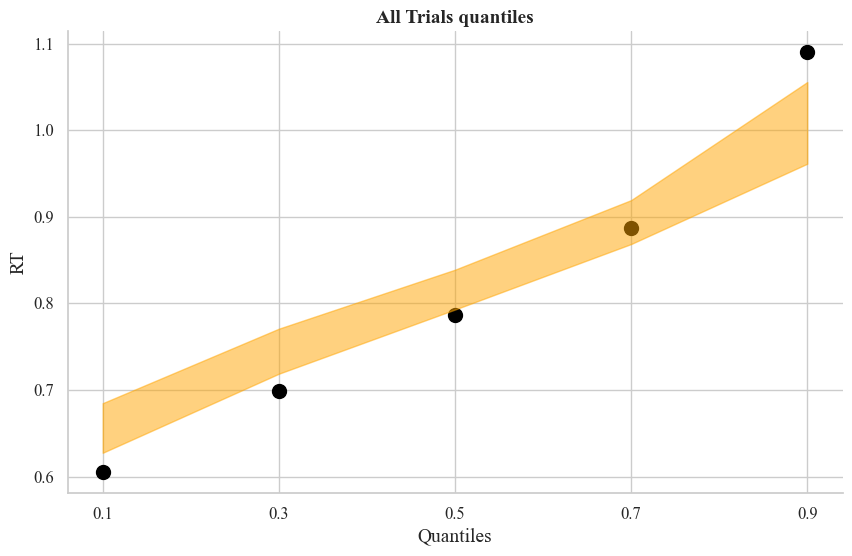

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

ax.set_title("All Trials quantiles", fontweight="bold", size=14)
ax.scatter(quantiles, all_quantiles_ex, color="black", s=100)

ax.fill_between(quantiles,
                all_predicted_bci[:, 0],
                all_predicted_bci[:, 1],
                all_predicted_bci[:, 0] < all_predicted_bci[:, 1],  color = "orange", alpha=0.5)

ax.set_xlabel("Quantiles", fontsize=14)
ax.set_xticks(quantiles)
ax.set_xticklabels(quantiles)
ax.set_ylabel("RT", fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-All Trials.pdf")

### All Trials (word response vs non-word response)

In [40]:
exp_word_resp_all, pred_word_resp_all = get_dfs(behavioural_df, predictedData,
                                                response=1)
exp_nonword_resp_all, pred_nonword_resp_all = get_dfs(behavioural_df, predictedData,
                                                      response=0)

In [41]:
word_quantiles_ex = exp_word_resp_all["rt"].quantile(quantiles)
nonword_quantiles_ex = exp_nonword_resp_all["rt"].quantile(quantiles)

word_quantiles_pred = pred_word_resp_all.quantile(quantiles, axis=1).T
nonword_quantiles_pred = pred_nonword_resp_all.quantile(quantiles, axis=1).T

word_predicted_bci = np.array([bci(word_quantiles_pred[x]) for x in quantiles])
nonword_predicted_bci = np.array([bci(nonword_quantiles_pred[x]) for x in quantiles])

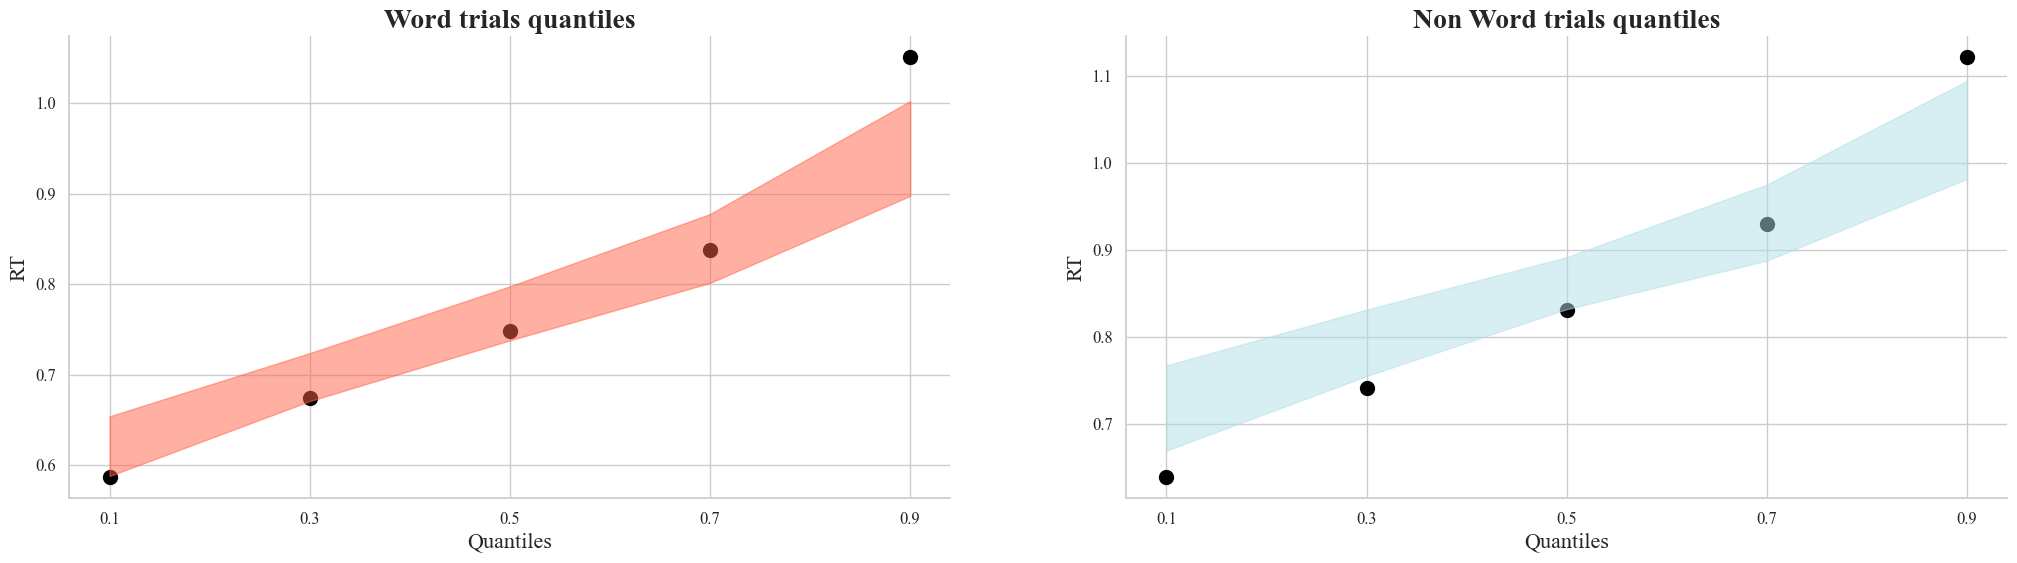

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title("Word trials quantiles", fontweight="bold", size=20)
axes[1].set_title("Non Word trials quantiles", fontweight="bold", size=20)

axes[0].scatter(quantiles, word_quantiles_ex, color="black", s=100)
axes[1].scatter(quantiles, nonword_quantiles_ex, color="black", s=100)

axes[0].fill_between(quantiles,
                word_predicted_bci[:, 0],
                word_predicted_bci[:, 1],
                word_predicted_bci[:, 0] < word_predicted_bci[:, 1],  color = "tomato", alpha=0.5)

axes[1].fill_between(quantiles,
                nonword_predicted_bci[:, 0],
                nonword_predicted_bci[:, 1],
                nonword_predicted_bci[:, 0] < nonword_predicted_bci[:, 1],  color = "powderblue", alpha=0.5)

for ax in axes:
        ax.set_xlabel("Quantiles", fontsize=16)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel("RT", fontsize=16)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-All Trials-Word vs Nonword.pdf")

### All trials (Correct Choice vs Incorrect Choice) 

In [43]:
exp_cor_choice_all, _ = get_dfs(behavioural_df, predictedData,
                                accuracy=1)
exp_incor_resp_all, _ = get_dfs(behavioural_df, predictedData,
                                accuracy=0)
pred_cor_choice_all = predictedData["rt"][predictedData["response"]==behavioural_df["label"]]
pred_incor_choice_all = predictedData["rt"][predictedData["response"]!=behavioural_df["label"]]

In [44]:
cor_quantiles_ex = exp_cor_choice_all["rt"].quantile(quantiles)
incor_quantiles_ex = exp_incor_resp_all["rt"].quantile(quantiles)

cor_quantiles_pred = pred_cor_choice_all.quantile(quantiles, axis=1).T
incor_quantiles_pred = pred_incor_choice_all.quantile(quantiles, axis=1).T

cor_predicted_bci = np.array([bci(cor_quantiles_pred[x]) for x in quantiles])
incor_predicted_bci = np.array([bci(incor_quantiles_pred[x]) for x in quantiles])

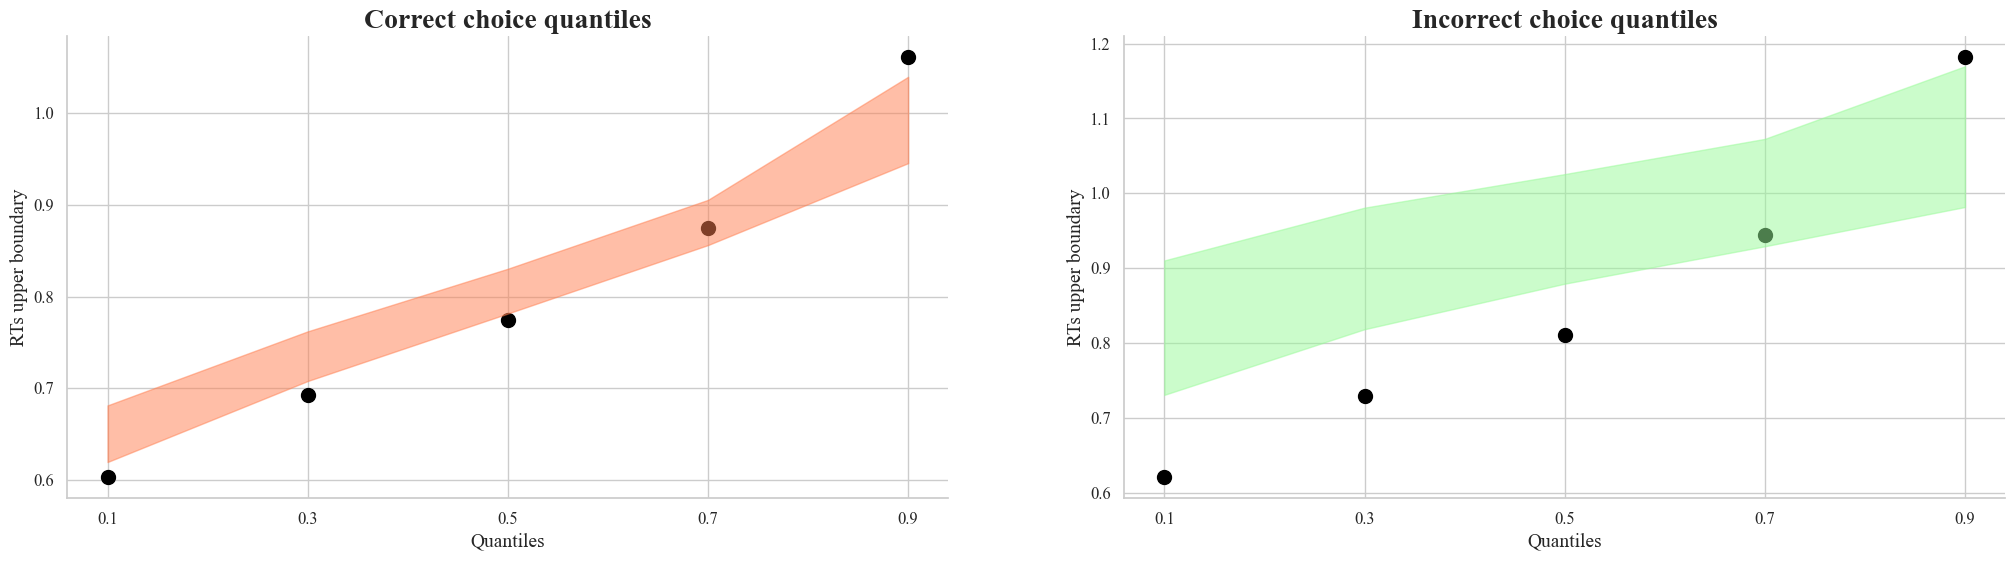

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title("Correct choice quantiles", fontweight="bold", size=20)
axes[1].set_title("Incorrect choice quantiles", fontweight="bold", size=20)

axes[0].scatter(quantiles, cor_quantiles_ex, color="black", s=100)
axes[1].scatter(quantiles, incor_quantiles_ex, color="black", s=100)

axes[0].fill_between(quantiles,
                cor_predicted_bci[:, 0],
                cor_predicted_bci[:, 1],
                cor_predicted_bci[:, 0] < cor_predicted_bci[:, 1],  color = "coral", alpha=0.5)

axes[1].fill_between(quantiles,
                incor_predicted_bci[:, 0],
                incor_predicted_bci[:, 1],
                incor_predicted_bci[:, 0] < incor_predicted_bci[:, 1],  color = "palegreen", alpha=0.5)

for ax in axes:
        ax.set_xlabel("Quantiles", fontsize=14)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel("RTs upper boundary", fontsize=14)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-All Trials-Correct vs Incorrect.pdf")

### Conditional (HF, LF, NW trials)

In [46]:
exp_HF_trials, pred_HF_trials = get_dfs(behavioural_df, predictedData,
                                        category="HF")
exp_LF_trials, pred_LF_trials = get_dfs(behavioural_df, predictedData,
                                        category="LF")
exp_NW_trials, pred_NW_trials = get_dfs(behavioural_df, predictedData,
                                        category="NW")

In [47]:
# experiment Data quantile
HF_quantile_ex = exp_HF_trials["rt"].quantile(quantiles)
LF_quantile_ex = exp_LF_trials["rt"].quantile(quantiles)
NW_quantile_ex = exp_NW_trials["rt"].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = pred_HF_trials.quantile(quantiles, axis=1).T
LF_quantile_pred = pred_LF_trials.quantile(quantiles, axis=1).T
NW_quantile_pred = pred_NW_trials.quantile(quantiles, axis=1).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

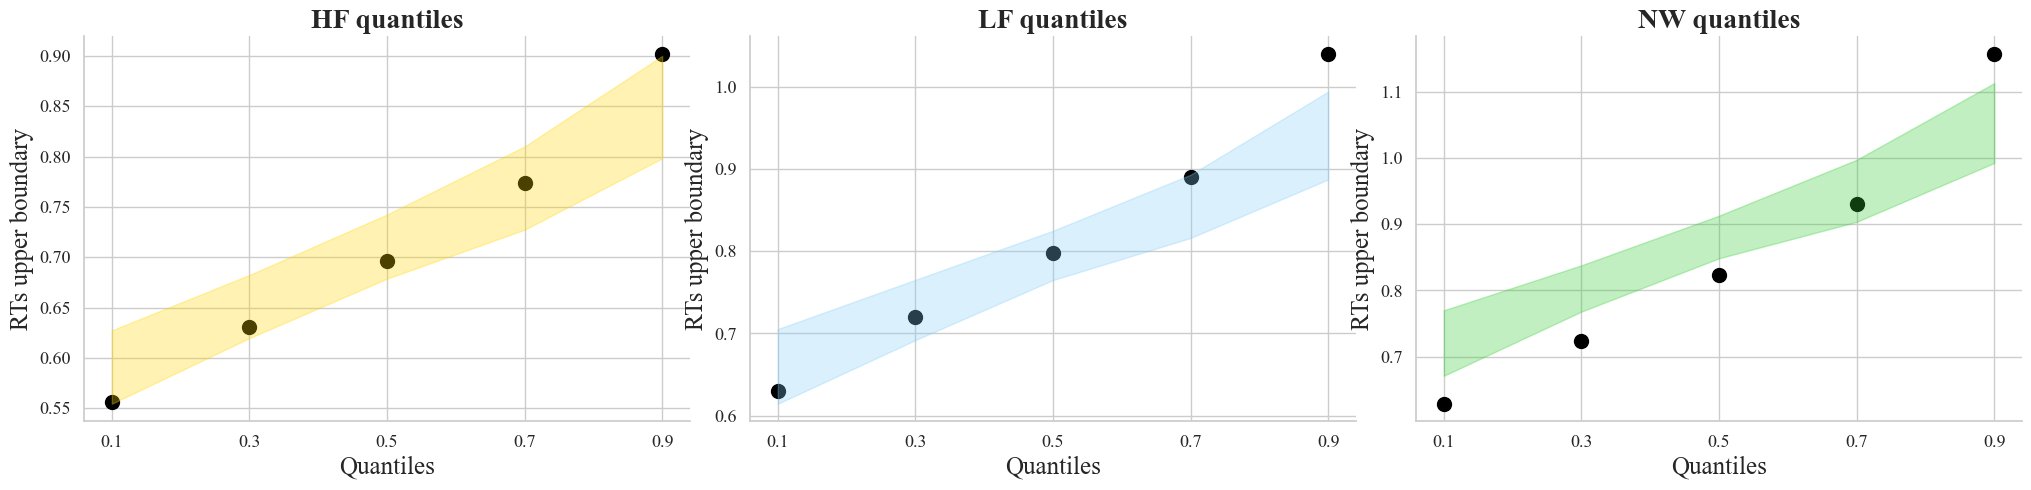

In [48]:
fig, axes = plt.subplots(1,3 , figsize=(25,5))
plt.subplots_adjust(wspace=0.1, hspace=0.5)

axes[0].set_title("HF quantiles", fontweight="bold", size=20)
axes[1].set_title("LF quantiles", fontweight="bold", size=20)
axes[2].set_title("NW quantiles", fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color="black", s=100)
axes[1].scatter(quantiles, LF_quantile_ex, color="black", s=100)
axes[2].scatter(quantiles, NW_quantile_ex, color="black", s=100)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = "gold", alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = "lightskyblue", alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = "limegreen", alpha=0.3)


for ax in axes:
        ax.set_xlabel("Quantiles", fontsize=18)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel("RTs upper boundary", fontsize=18)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(13)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-Conditional.pdf")

### Conditional (HF, LF, NW trials) for word response and nonword response

In [49]:
exp_word_resp_HF, pred_word_resp_HF = get_dfs(behavioural_df, predictedData,
                                              category="HF", response=1)
exp_word_resp_LF, pred_word_resp_LF = get_dfs(behavioural_df, predictedData,
                                              category="LF", response=1)
exp_word_resp_NW, pred_word_resp_NW = get_dfs(behavioural_df, predictedData,
                                              category="NW", response=1)

exp_nonword_resp_HF, pred_nonword_resp_HF = get_dfs(behavioural_df, predictedData,
                                                    category="HF", response=0)
exp_nonword_resp_LF, pred_nonword_resp_LF = get_dfs(behavioural_df, predictedData,
                                                    category="LF", response=0)
exp_nonword_resp_NW, pred_nonword_resp_NW = get_dfs(behavioural_df, predictedData,
                                                    category="NW", response=0)

In [50]:
# experiment Data quantile
HF_word_quantile_ex = exp_word_resp_HF["rt"].quantile(quantiles)
LF_word_quantile_ex = exp_word_resp_LF["rt"].quantile(quantiles)
NW_word_quantile_ex = exp_word_resp_NW["rt"].quantile(quantiles)

HF_nonword_quantile_ex = exp_nonword_resp_HF["rt"].quantile(quantiles)
LF_nonword_quantile_ex = exp_nonword_resp_LF["rt"].quantile(quantiles)
NW_nonword_quantile_ex = exp_nonword_resp_NW["rt"].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_word_quantile_pred = pred_word_resp_HF.quantile(quantiles, axis=1).T
LF_word_quantile_pred = pred_word_resp_LF.quantile(quantiles, axis=1).T
NW_word_quantile_pred = pred_word_resp_NW.quantile(quantiles, axis=1).T

HF_nonword_quantile_pred = pred_nonword_resp_HF.quantile(quantiles, axis=1).T
LF_nonword_quantile_pred = pred_nonword_resp_LF.quantile(quantiles, axis=1).T
NW_nonword_quantile_pred = pred_nonword_resp_NW.quantile(quantiles, axis=1).T


# predicted data quantiles bci
HF_word_predicted_bci = np.array([bci(HF_word_quantile_pred[x]) for x in quantiles])
LF_word_predicted_bci = np.array([bci(LF_word_quantile_pred[x]) for x in quantiles])
NW_word_predicted_bci = np.array([bci(NW_word_quantile_pred[x]) for x in quantiles])

HF_nonword_predicted_bci = np.array([bci(HF_nonword_quantile_pred[x]) for x in quantiles])
LF_nonword_predicted_bci = np.array([bci(LF_nonword_quantile_pred[x]) for x in quantiles])
NW_nonword_predicted_bci = np.array([bci(NW_nonword_quantile_pred[x]) for x in quantiles])

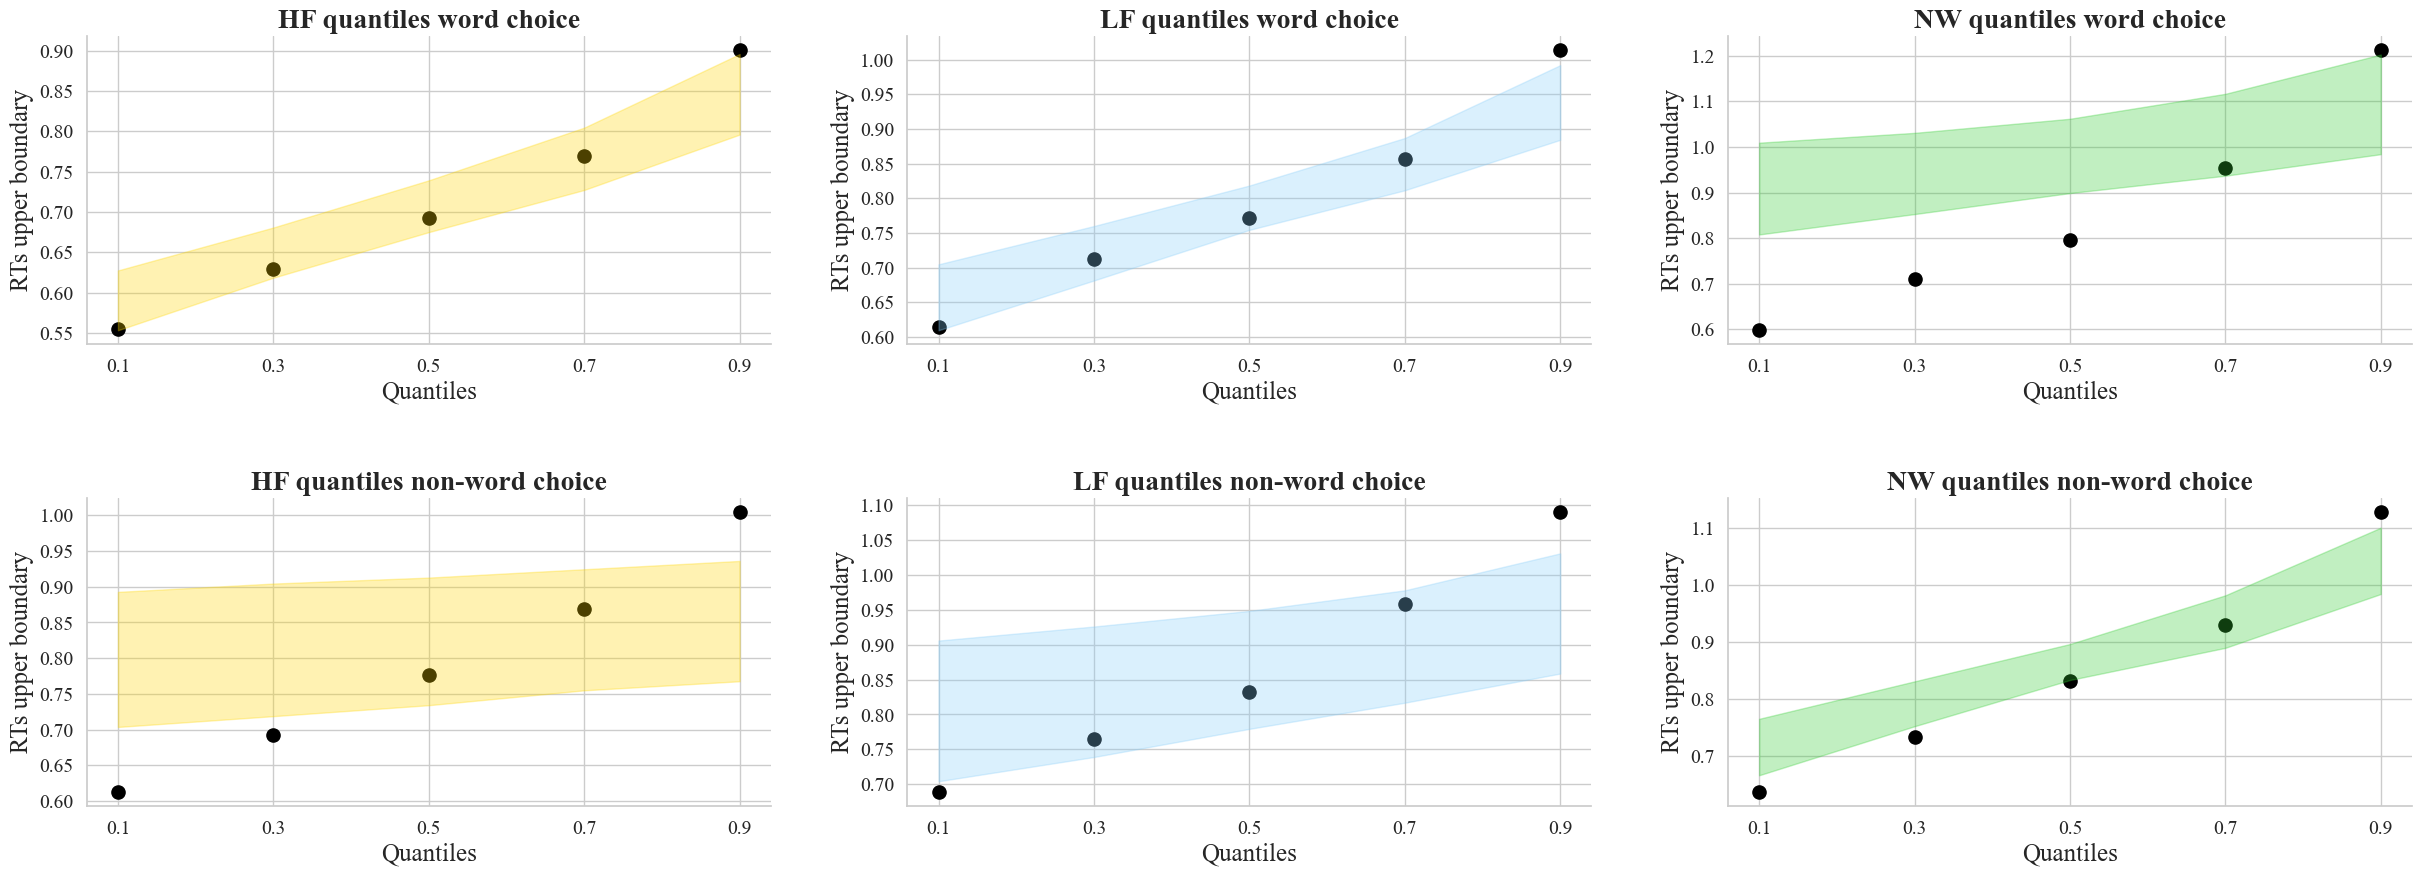

In [51]:
fig, axes = plt.subplots(2,3 , figsize=(30,10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0][0].set_title("HF quantiles word choice", fontweight="bold", size=20)
axes[0][1].set_title("LF quantiles word choice", fontweight="bold", size=20)
axes[0][2].set_title("NW quantiles word choice", fontweight="bold", size=20)

axes[1][0].set_title("HF quantiles non-word choice", fontweight="bold", size=20)
axes[1][1].set_title("LF quantiles non-word choice", fontweight="bold", size=20)
axes[1][2].set_title("NW quantiles non-word choice", fontweight="bold", size=20)

axes[0][0].scatter(quantiles, HF_word_quantile_ex, color="black", s=90)
axes[0][1].scatter(quantiles, LF_word_quantile_ex, color="black", s=90)
axes[0][2].scatter(quantiles, NW_word_quantile_ex, color="black", s=90)

axes[1][0].scatter(quantiles, HF_nonword_quantile_ex, color="black", s=90)
axes[1][1].scatter(quantiles, LF_nonword_quantile_ex, color="black", s=90)
axes[1][2].scatter(quantiles, NW_nonword_quantile_ex, color="black", s=90)


axes[0][0].fill_between(quantiles,
                HF_word_predicted_bci[:, 0],
                HF_word_predicted_bci[:, 1],
                HF_word_predicted_bci[:, 0] < HF_word_predicted_bci[:, 1],  color = "gold", alpha=0.3)

axes[0][1].fill_between(quantiles,
                LF_word_predicted_bci[:, 0],
                LF_word_predicted_bci[:, 1],
                LF_word_predicted_bci[:, 0] < LF_word_predicted_bci[:, 1],  color = "lightskyblue", alpha=0.3)

axes[0][2].fill_between(quantiles,
                NW_word_predicted_bci[:, 0],
                NW_word_predicted_bci[:, 1],
                NW_word_predicted_bci[:, 0] < NW_word_predicted_bci[:, 1],  color = "limegreen", alpha=0.3)


axes[1][0].fill_between(quantiles,
                HF_nonword_predicted_bci[:, 0],
                HF_nonword_predicted_bci[:, 1],
                HF_nonword_predicted_bci[:, 0] < HF_nonword_predicted_bci[:, 1],  color = "gold", alpha=0.3)

axes[1][1].fill_between(quantiles,
                LF_nonword_predicted_bci[:, 0],
                LF_nonword_predicted_bci[:, 1],
                LF_nonword_predicted_bci[:, 0] < LF_nonword_predicted_bci[:, 1],  color = "lightskyblue", alpha=0.3)

axes[1][2].fill_between(quantiles,
                NW_nonword_predicted_bci[:, 0],
                NW_nonword_predicted_bci[:, 1],
                NW_nonword_predicted_bci[:, 0] < NW_nonword_predicted_bci[:, 1],  color = "limegreen", alpha=0.3)


for ax_d1 in axes:
    for ax in ax_d1:
        ax.set_xlabel("Quantiles", fontsize=18)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel("RTs upper boundary", fontsize=18)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(14) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-Conditional-Word vs Nonword.pdf")

## Mean Accuracy and RT Posterior Prediction Checks


### All trials

In [52]:
exp_all_trials_rt, pred_all_trials_rt = get_dfs(behavioural_df, predictedData)
exp_all_trials_resp, pred_all_trials_resp = get_dfs(behavioural_df, predictedData,
                                                    pred_df_type="response")

In [53]:
all_data_rt_mean = exp_all_trials_rt["rt"].mean()
all_pred_rt_mean = pred_all_trials_rt.mean(axis=1)

all_data_resp_mean = exp_all_trials_resp["response"].mean()
all_pred_resp_mean = pred_all_trials_resp.mean(axis=1)

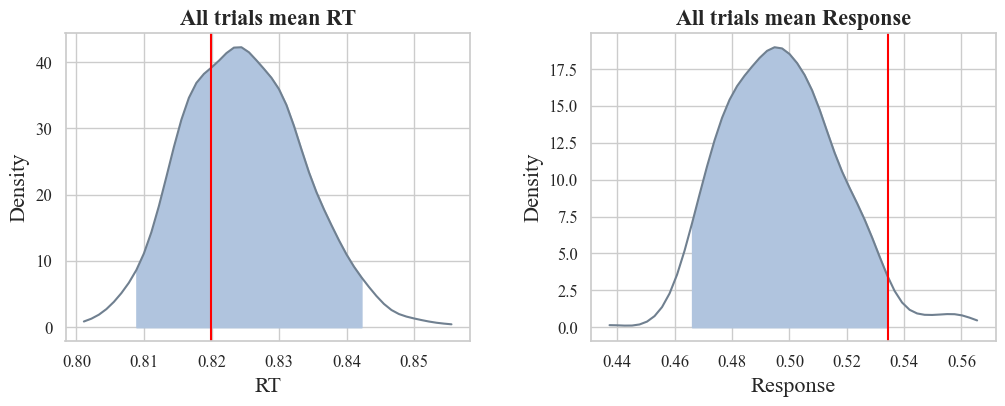

In [54]:
fig, axes = plt.subplots(1,2 , figsize=(12, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0].set_title("All trials mean RT", fontweight="bold", size=16)
axes[1].set_title("All trials mean Response", fontweight="bold", size=16)

plot_mean_posterior(all_pred_rt_mean, all_data_rt_mean, axes[0])
plot_mean_posterior(all_pred_resp_mean, all_data_resp_mean, axes[1])

axes[0].set_xlabel("RT", fontsize=16)
axes[1].set_xlabel("Response", fontsize=16)

for ax in axes:
        ax.set_ylabel("Density", fontsize=16)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
            
plt.savefig(plots_path + "PPC-Mean Accuracy and RT-All trials.pdf")

### All Trials (correct choice vs incorrect choice)

In [55]:
exp_cor_all_trials_rt, pred_cor_all_trials_rt = get_dfs(behavioural_df, predictedData,
                                                        accuracy=1)
exp_incor_all_trials_rt, pred_incor_all_trials_rt = get_dfs(behavioural_df, predictedData,
                                                            accuracy=0)

exp_cor_all_trials_resp, pred_cor_all_trials_resp = get_dfs(behavioural_df, predictedData,
                                                            accuracy=1, pred_df_type="response")
exp_incor_all_trials_resp, pred_incor_all_trials_resp = get_dfs(behavioural_df, predictedData,
                                                                accuracy=0, pred_df_type="response")

In [56]:
all_trials_cor_rt_mean = exp_cor_all_trials_rt["rt"].mean()
all_pred_cor_rt_mean = pred_cor_all_trials_rt.mean(axis=1)

all_trials_incor_rt_mean = exp_incor_all_trials_rt["rt"].mean()
all_pred_incor_rt_mean = pred_incor_all_trials_rt.mean(axis=1)


all_data_cor_resp_mean = exp_cor_all_trials_resp["response"].mean()
all_pred_cor_resp_mean = pred_cor_all_trials_resp.mean(axis=1)

all_data_incor_resp_mean = exp_incor_all_trials_resp["response"].mean()
all_pred_incor_resp_mean = pred_incor_all_trials_resp.mean(axis=1)

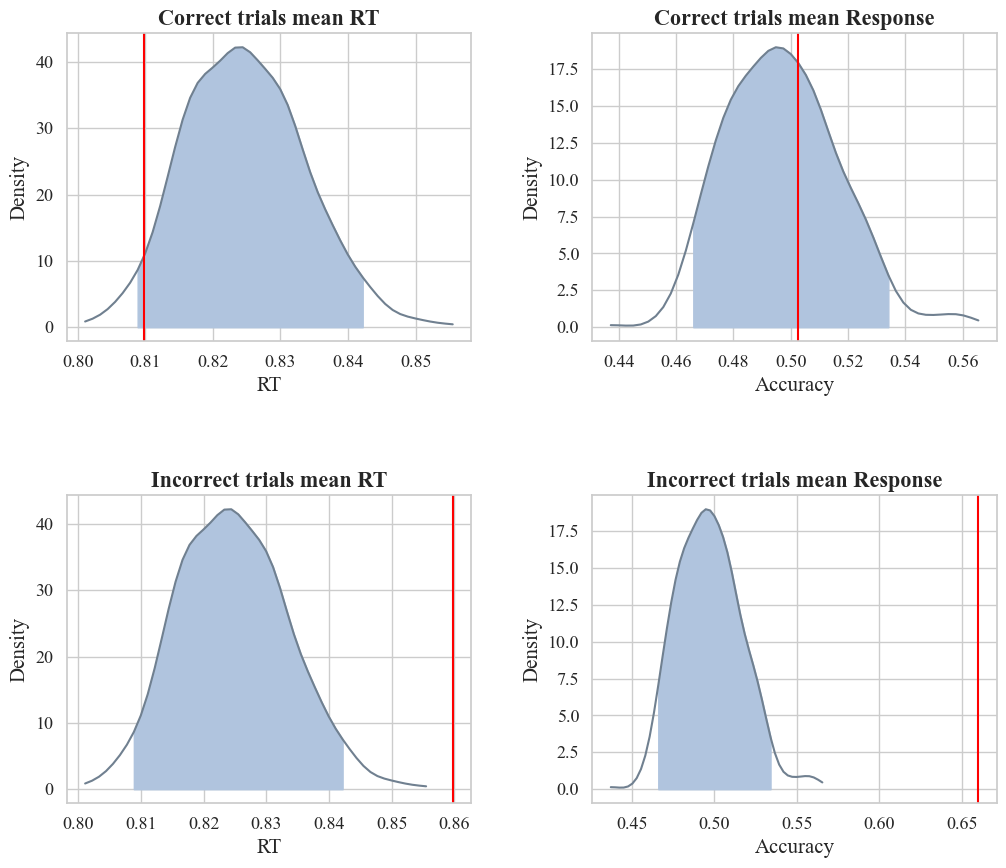

In [57]:
fig, axes = plt.subplots(2,2 , figsize=(12,10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title("Correct trials mean RT", fontweight="bold", size=16)
axes[0][1].set_title("Correct trials mean Response", fontweight="bold", size=16)
axes[1][0].set_title("Incorrect trials mean RT", fontweight="bold", size=16)
axes[1][1].set_title("Incorrect trials mean Response", fontweight="bold", size=16)

plot_mean_posterior(all_pred_cor_rt_mean, all_trials_cor_rt_mean, axes[0][0])
plot_mean_posterior(all_pred_cor_resp_mean, all_data_cor_resp_mean, axes[0][1])

plot_mean_posterior(all_pred_incor_rt_mean, all_trials_incor_rt_mean, axes[1][0])
plot_mean_posterior(all_pred_incor_resp_mean, all_data_incor_resp_mean, axes[1][1])

for ax in axes:
        ax[0].set_xlabel("RT", fontsize=15)
        ax[1].set_xlabel("Accuracy", fontsize=15)
        ax[0].set_ylabel("Density", fontsize=15)
        ax[1].set_ylabel("Density", fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

plt.savefig(plots_path + "PPC-Mean Accuracy and RT-All trials-Correct vs Incorrect.pdf")

### Conditional (HF, LF, NW trials) 

In [58]:
exp_HF_trials_rt, pred_HF_trials_rt = get_dfs(behavioural_df, predictedData,
                                              category="HF")
exp_LF_trials_rt, pred_LF_trials_rt = get_dfs(behavioural_df, predictedData,
                                              category="LF")
exp_NW_trials_rt, pred_NW_trials_rt = get_dfs(behavioural_df, predictedData,
                                              category="NW")

exp_HF_trials_resp, pred_HF_trials_resp = get_dfs(behavioural_df, predictedData,
                                                  category="HF", pred_df_type="response")
exp_LF_trials_resp, pred_LF_trials_resp = get_dfs(behavioural_df, predictedData,
                                                  category="LF", pred_df_type="response")
exp_NW_trials_resp, pred_NW_trials_resp = get_dfs(behavioural_df, predictedData,
                                                  category="NW", pred_df_type="response")

In [59]:
HF_data_rt_mean = exp_HF_trials_rt["rt"].mean()
LF_data_rt_mean = exp_LF_trials_rt["rt"].mean()
NW_data_rt_mean = exp_NW_trials_rt["rt"].mean()

HF_pred_rt_mean = pred_HF_trials_rt.mean(axis=1)
LF_pred_rt_mean = pred_LF_trials_rt.mean(axis=1)
NW_pred_rt_mean = pred_NW_trials_rt.mean(axis=1)


HF_data_resp_mean = exp_HF_trials_resp["response"].mean()
LF_data_resp_mean = exp_LF_trials_resp["response"].mean()
NW_data_resp_mean = exp_NW_trials_resp["response"].mean()

HF_pred_resp_mean = pred_HF_trials_resp.mean(axis=1)
LF_pred_resp_mean = pred_LF_trials_resp.mean(axis=1)
NW_pred_resp_mean = pred_NW_trials_resp.mean(axis=1)


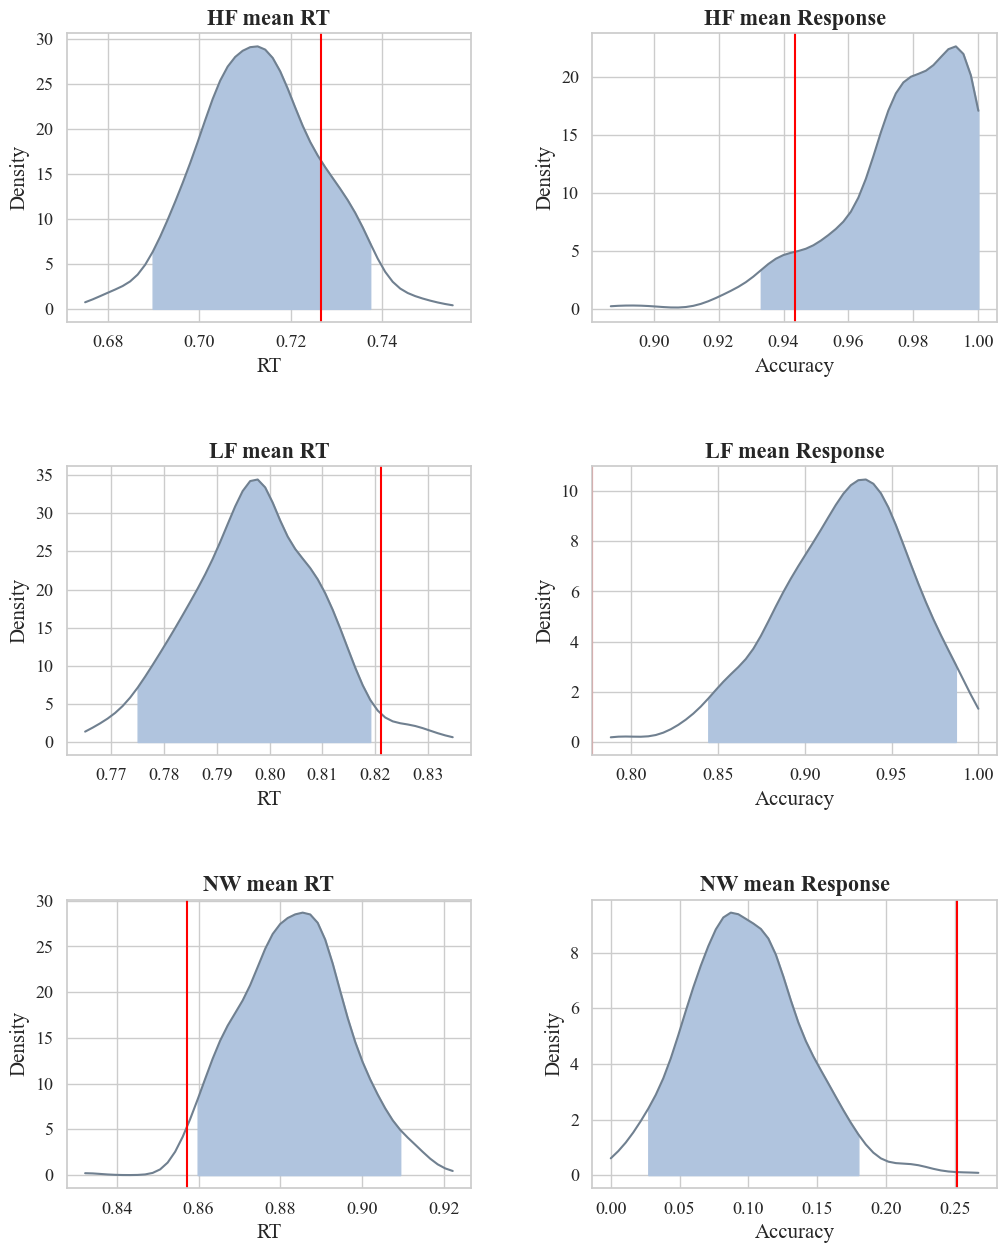

In [60]:
fig, axes = plt.subplots(3,2 , figsize=(12,15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title("HF mean RT", fontweight="bold", size=16)
axes[0][1].set_title("HF mean Response", fontweight="bold", size=16)
axes[1][0].set_title("LF mean RT", fontweight="bold", size=16)
axes[1][1].set_title("LF mean Response", fontweight="bold", size=16)
axes[2][0].set_title("NW mean RT", fontweight="bold", size=16)
axes[2][1].set_title("NW mean Response", fontweight="bold", size=16)

plot_mean_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_mean_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_mean_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_mean_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_mean_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_mean_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel("RT", fontsize=15)
        ax[1].set_xlabel("Accuracy", fontsize=15)
        ax[0].set_ylabel("Density", fontsize=15)
        ax[1].set_ylabel("Density", fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

plt.savefig(plots_path + "PPC-Mean Accuracy and RT-Conditional.pdf")